# Walker Example

In [6]:
import sys
sys.path.append('lib')

import numpy as np
import matplotlib.pyplot as plt
import os, time

from IPython.core import display

import pybullet as p
import pybullet_data
from scipy.optimize import fmin_bfgs
from functools import partial

import tensorflow as tf
import tensorflow.compat.v1 as tf1
import tf_robot_learning as rl
import tf_robot_learning.distributions as ds
from tf_robot_learning import kinematic as tk

from pb_utils.kine import get_joint_limits, check_joint_limits
from pb_utils.visualize import set_q, vis_traj, create_primitives
from pin_utils.pin_utils import computeJacobian, computePose

from residuals import ResidualFrameTranslationFloatingBase, ResidualFrameRotationSE3FloatingBase, ResidualBound, \
                        ResidualPosture, ResidualSum, ResidualStructure, CostProjector, clip_bounds
from motion_planning import sampler

DATA_PATH = '/home/teguh/git/rli/learning_distribution_gan/tf_robot_learning/data'

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 1: Define and Train GAN

In [2]:
sess = tf1.InteractiveSession()
tf1.disable_eager_execution()

### Define robot

In [3]:
from collections import OrderedDict

In [7]:
urdf = tk.urdf_from_file(DATA_PATH + '/urdf/walker_description/urdf/walker.urdf');
display.clear_output()

#list of end-effector
tips = OrderedDict({
    'r_gripper'	: 'right_palm_link',
    'l_gripper'	: 'left_palm_link',
    'r_foot' 	: 'right_sole',
    'l_foot' 	: 'left_sole',
})

#define the robot as a kinematic chain, loaded from urdf
chain_names = ['r_gripper', 'r_foot', 'l_foot'] 
chain = tk.ChainDict({
    name: tk.kdl_chain_from_urdf_model(urdf, 'base_link', tip=tip)
    for name, tip in tips.items()
})

#define the default position and orientation of the end-effector
# ee = OrderedDict({
#         'l_gripper': [0.  , 0.29, 0.8 , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ,1.  ],
#         'r_gripper': [0.  , -0.29, 0.8 , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ,1.  ],
#         'l_foot': [-0.02,  0.09, -0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  , 0.  ,  0.  ,  1.  ],
#         'r_foot': [-0.02,  -0.09, -0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  , 0.  ,  0.  ,  1.  ],
# })

In [8]:
ee = OrderedDict({
        'l_gripper': [0.  , 0.29, 0.8 , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ,1.  ],
        'r_gripper': [0.  , -0.29, 0.8 , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ,1.  ],
        'l_foot': [-0.0,  0.11, -0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  , 0.  ,  0.  ,  1.  ],
        'r_foot': [-0.0,  -0.11, -0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  , 0.  ,  0.  ,  1.  ],
})

### Load data 

In [9]:
def param_to_joint_pos(x):
    """
    convert the config parameter x to full robot configurations: joint angles, base position and orientation
    """
    return x[..., :chain.nb_joint],\
        tf.concat([x[..., chain.nb_joint:chain.nb_joint+3]], -1),\
        tk.rotation.rpy(tf.zeros_like(x[..., -3:]))

In [10]:
def q_augmented(q):
    """ Define augmented data transformations: (joint_angles, right foot pose, and left foot pose)"""
    _q, _p, _m = param_to_joint_pos(q)
    return tf.concat([
            q,
            chain.xs(_q, floating_base=(_p, _m), name='r_foot')[:, -1],
            chain.xs(_q, floating_base=(_p, _m), name='l_foot')[:, -1]
        ], -1)

In [11]:
def q_target(q):
    """ Extract the target"""
    _q, _p, _m = param_to_joint_pos(q)
    return tf.concat( # orientation of each foot
            [chain.xs(_q, floating_base=(_p, _m), name=name)[:, -1, :3] for name in chain_names]
            , -1)

In [12]:
def q_foot_ori(q):
    """ Extract the foot orientation """
    _q, _p, _m = param_to_joint_pos(q)
    return tf.concat( # position of each end-effector
            [chain.xs(_q, floating_base=(_p, _m), name=name)[:, -1, 3:] for name in chain_names[1:]]
            , -1)

In [13]:
# get mini batch
def get_batch(_batch_size=30, cut=None, augmented=True):
    if cut is not None: idx = np.random.randint(0, cut, _batch_size)
    else: idx = np.random.randint(0, data_augmented.shape[0]-1, _batch_size)
    if augmented: return data_augmented[idx]
    else: return data[idx]
    
def get_target_batch(_batch_size=30, cut=None):
    if cut is not None: idx = np.random.randint( 0, cut, _batch_size)
    else: idx = np.random.randint(0, data_augmented.shape[0]-1, _batch_size)
    return data_target[idx]


In [14]:
# tf2pb_indices = []
# for name in chain.actuated_joint_names:
#     name = list(name)
#     name[-2] = 'j'
#     name = "".join(name)
#     idx = pb_joint_indices_names.index(name)
#     tf2pb_indices += [idx]

# tf2pb_indices = np.array(tf2pb_indices)

tf2pb_indices = np.array([31, 32, 33, 34, 35, 36, 37,  8,  9, 10, 11, 12, 13, 14, 25, 26, 27,
       28, 29, 30,  2,  3,  4,  5,  6,  7])

In [15]:
def conv_tf2pb_config(q):
    N = len(q)
    q_pb = np.zeros((N, 48 + 7))
    q_pb[:,6] = 1.
    q_pb[:,:3] = q[:,-3:]
    q_pb[:,tf2pb_indices+7] = q[:,:-3]
    return q_pb
    
def conv_pb2tf_config(q):
    N = len(q)
    q_tf = np.zeros((N, 26 + 3))
    q_tf[:,-3:] = q[:,:3]
    q_tf[:,:-3] = q[:,tf2pb_indices+7]
    return q_tf

In [16]:
q_eval = tf1.placeholder(tf.float32, (None, chain.nb_joint + 3))

q_augmented_eval = q_augmented(q_eval)
q_target_eval = q_target(q_eval)
q_foot_ori_eval = q_foot_ori(q_eval)

In [17]:
#load the dataset
pb_data = np.load('data/data_two_feet_walker.npy')

In [18]:
data = conv_pb2tf_config(pb_data)

In [19]:
# compute data through these transformations
data_augmented = q_augmented_eval.eval({q_eval: data})
data_target = q_target_eval.eval({q_eval: data})

## Generator 

In [20]:
# Network Parameters
joint_dim = chain.nb_joint + 3 # the configuration consists of nb_joint= 28 joint angles and 3 base position
latent_dim = 30 # dimension of noise
N_net = 10
target_dim = 9  # size of the target
augmented_dim = 2 * 12 + joint_dim # size of augmented data (joint angles + poses of both foot)

n_input = latent_dim + target_dim #dimension of the input to the generator
batch_size = tf1.placeholder(tf.int32, ())

#### Define the generator

In [21]:
gen_nn = rl.nn.MLP(
    n_input=n_input, n_output=joint_dim, n_hidden=[200, 200],
    act_fct=tf.nn.relu, batch_size_svi=N_net
)

#### Define the generator input

In [22]:
# noise to feed generator
eps_var = tf1.placeholder(tf.float32, ())
eps = tf.random.normal([tf.cast(batch_size/N_net, tf.int32), latent_dim], 
    dtype=tf.float32, mean=0., stddev=eps_var, name='epsilon')

#the input to generator = noise + target
batch_target = tf1.placeholder(tf.float32, (None, target_dim))
eps_conc = tf.concat([eps, batch_target], axis=-1)

#### Define output transformations

In [23]:
# samples_q = tf.reshape(gen_nn.pred(eps_conc) + tf.constant(chain.mean_pose + [0,0,1.14])[None], (-1, joint_dim))
samples_q = tf.reshape(gen_nn.pred(eps_conc) + tf.constant(chain.mean_pose + [0,0,0.9])[None], (-1, joint_dim))

samples_qq, samples_p, samples_m = param_to_joint_pos(samples_q)
samples_links, _, samples_com = chain.xs(samples_qq, floating_base=(samples_p, samples_m), get_links=True)

samples_augmented = q_augmented(samples_q)
samples_target = q_target(samples_q)
samples_foot_ori = q_foot_ori(samples_q)

## Discriminator

#### Define the discriminator

In [24]:
discr_nn = rl.nn.MLP(
    n_input=augmented_dim, n_output=1, n_hidden=[40, 40],
    act_fct=tf.nn.relu
)

#batch data
batch_x = tf1.placeholder(tf.float32, (None, augmented_dim))

## Define loss functions

#### Main loss functions (discriminator vs generator)

In [25]:
d_fake = discr_nn.pred(samples_augmented)[:, 0]
d_true = discr_nn.pred(batch_x)[:, 0]

#discriminator loss function
loss_d = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_true), logits=d_true) + \
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_fake), logits=d_fake)
loss_d = tf.reduce_sum(loss_d)

#generator (basic) loss function
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.ones_like(d_fake), logits=d_fake)
loss = tf.reduce_sum(loss)

#### Target loss 

In [26]:
p_target_std = tf1.placeholder(tf.float32, ()) 

p_target = ds.MultivariateNormalFullCovariance(
    tf.reshape(tf.ones((N_net, 1,1))*batch_target,(-1, target_dim)), p_target_std**2 * tf.eye(target_dim)
)

loss_target = tf.reduce_sum(-p_target.log_prob(samples_target))
# loss_target = (-p_target.log_prob(samples_target))
lmbda_target = tf1.placeholder(tf.float32, ())

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


#### Foot orientation loss 

In [27]:
foot_ori_dim = 18
batch_foot_ori = tf1.placeholder(tf.float32, (None, foot_ori_dim))

# define a Gaussian distribution that should be tracked by the system
p_foot_ori_std = tf1.placeholder(tf.float32, ()) 

p_foot_ori = ds.MultivariateNormalFullCovariance(
    tf.reshape(tf.ones((N_net, 1,1))*batch_foot_ori,(-1, foot_ori_dim)), p_foot_ori_std**2 * tf.eye(foot_ori_dim)
)

loss_foot_ori = tf.reduce_sum(-p_foot_ori.log_prob(samples_foot_ori))
# loss_foot_ori = tf.reduce_mean(-p_foot_ori.log_prob(samples_foot_ori))
lmbda_foot_ori = tf1.placeholder(tf.float32, ())

#### Constraints cost: COM and joint limit

In [28]:
#joint limit
base_pos_limits = np.array([[-0.05, -0.05, 0.8],[0.1, 0.1, 1.2] ]).T
config_limits = np.concatenate([chain.joint_limits, base_pos_limits], axis=0)
joint_limits = tf.constant(config_limits, dtype=tf.float32)
joint_limits_std = 0.05
joint_limits_temp = 1.

joint_limits_exp = ds.SoftUniformNormalCdf(
    low=joint_limits[:, 0],
    high=joint_limits[:, 1],
    std=joint_limits_std,
    temp=joint_limits_temp,
    reduce_axis=-1
)

joint_limit_constraints = tf.reduce_mean(-joint_limits_exp.log_prob(samples_q[:,:chain.nb_joint+3]))
# joint_limit_constraints = (-joint_limits_exp.log_prob(samples_q[:,:chain.nb_joint+3]))


#COM
com_limits = 0.05
com_limits_std = 0.01

com_limits_exp = ds.SoftUniformNormalCdf(
    low=-com_limits,
    high=com_limits,
    std=com_limits_std,
    temp=1.,
    reduce_axis=-1
)

com_xy = samples_com[:, :2]
center_feet = tf.reduce_mean([
        samples_links['r_foot'][:, -1, :2], 
        samples_links['l_foot'][:, -1, :2]
        ], axis=0)

cost_constraints = tf.reduce_mean(-com_limits_exp.log_prob(com_xy - center_feet))
# cost_constraints = (-com_limits_exp.log_prob(com_xy - center_feet))
lmbda_constraints = tf1.placeholder(tf.float32, ())

### Overall loss

In [29]:
loss_gen =  lmbda_target * loss_target + lmbda_foot_ori*loss_foot_ori + lmbda_constraints * (cost_constraints+joint_limit_constraints)  + loss

### Optimizer 

In [30]:
rate = tf1.placeholder(tf.float32, ())
opt = tf1.train.AdamOptimizer

optimizer = opt(learning_rate=rate)
optimizer_d = opt(learning_rate=rate)

train = optimizer.minimize(loss_gen, var_list=gen_nn.vec_weights)
train_d = optimizer_d.minimize(loss_d, var_list=discr_nn.vec_weights)

# Initialize the variables (i.e. assign their default value)
init = tf1.global_variables_initializer()

## Training model 

In [31]:
sess.run(init)

In [32]:
def get_target_new_batch(_batch_size):
    return np.random.multivariate_normal(_targets_m, np.diag(_targets_v ** 2), (_batch_size, ))

In [33]:
_batch_size = 100
_targets_m = np.concatenate([ee[name][:3] for name in chain_names], 0) # mean target
_batch_foot_ori = np.tile(np.eye(3).flatten(), (int(_batch_size/N_net),2)).reshape(int(_batch_size/N_net),-1)

_targets_m = np.concatenate([ee[name][:3] for name in chain_names], 0) # mean target
_targets_v = np.array([0.3] * 3 + [0.01] * 2 + [0.] +  [0.01] * 2 + [0.]  )  # variance

#### To save model

#### To load model

In [34]:
saver = tf1.train.Saver()
saver.restore(sess, "data/walker3.ckpt")

INFO:tensorflow:Restoring parameters from data/walker3.ckpt


### Visualize the generated samples

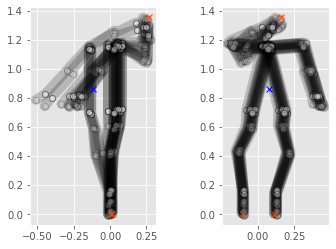

In [41]:
_batch_size = 10
feed_dict={batch_size: _batch_size, eps_var:1.}
feed_dict[batch_target] = get_target_new_batch(_batch_size=int(_batch_size/N_net))

_links, _com , _b_targets, _samples_q = sess.run(
[samples_links, samples_com, batch_target, samples_q], feed_dict
)

fig, ax = plt.subplots(ncols=2)

for i in range(2):
    dim = [i, 2]
    chain.plot(
            _links, feed_dict={}, ax=ax[i],
            dim=dim, alpha=0.2, color='k'
        )    
    ax[i].plot(_com[0, dim[0]], _com[0, dim[1]], 'bx')
    
    for j, name in enumerate(chain_names):
        ax[i].plot(_b_targets[:, j*3 + dim[0]], _b_targets[:, j*3 + dim[1]], 'rx', color='orangered')

q_pb = conv_tf2pb_config(_samples_q)

# set_q_std(q_pb[0])

# p.resetBasePositionAndOrientation(rh_box_id, _b_targets[0][:3], (0,0,0,1))

In [476]:
set_q_std(q_pb[0])


set_q_std(q_pb[1])


set_q_std(q_pb[2])


set_q_std(q_pb[3])


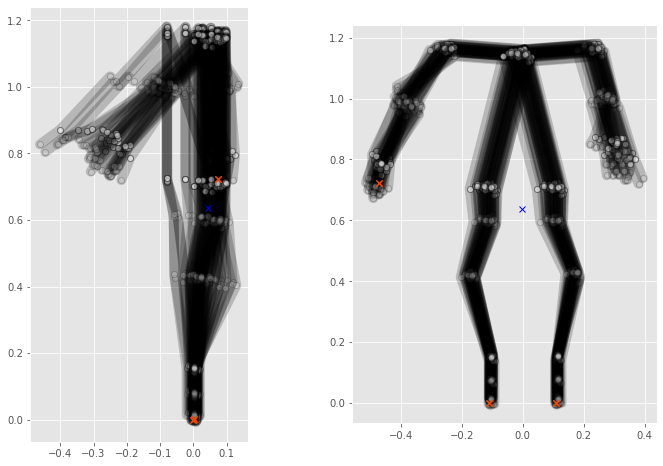

In [34]:
from_dataset = False
n = 30

_targets_m = np.concatenate([ee[name][:3] for name in chain_names], 0) # mean target
_targets_v = np.array([0.3] * 3 + [0.001]*3 + [0.001] * 3  )  # variance

if from_dataset:
    _targets = get_target_batch(cut=10000, _batch_size=1) * np.ones((int(n/N_net), 1))
else:
    _targets = np.random.multivariate_normal(_targets_m, np.diag(_targets_v ** 2), (1, )) * np.ones((int(n/N_net), 1))

feed_dict={batch_size: n, batch_target: _targets, eps_var:1.}


_links, _com , _b_targets, _samples_q = sess.run(
    [samples_links, samples_com, batch_target, samples_q], 
    feed_dict)

fig, ax = plt.subplots(ncols=2, figsize=(12,8))

for i in range(2):
    dim = [i, 2]
    chain.plot(
            _links, feed_dict={}, ax=ax[i],
            dim=dim, alpha=0.2, color='k'
        )    
    
    for j, name in enumerate(chain_names):
        ax[i].plot(_b_targets[:, j*3 + dim[0]], _b_targets[:, j*3 + dim[1]], 'rx', color='orangered')
    ax[i].plot(_com[0, dim[0]], _com[0, dim[1]], 'bx')
    #ax[i].set_xlim([-.7, .7])
    #x[i].set_ylim([-0.1, 1.2])
plt.savefig('data/talos_config.png')
plt.show()  


In [171]:
p.resetBasePositionAndOrientation(lf_box_id, pose_lf_ref[:3], (0,0,0,1))
p.resetBasePositionAndOrientation(rf_box_id, pose_rf_ref[:3], (0,0,0,1))

# Part 2: Use GAN for Projection, IK and Inverse Kinematics

### Setup Pybullet

In [2]:
physics_client_id = p.connect(p.GUI)

p.setPhysicsEngineParameter(enableFileCaching=0)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)

In [29]:
p.resetSimulation()

#### Load in pybullet

In [30]:
#load robot
robot_urdf = DATA_PATH + '/urdf/walker_description/urdf/walker.urdf';
robot_id = p.loadURDF(fileName=robot_urdf, flags=p.URDF_USE_INERTIA_FROM_FILE)
dof = p.getNumJoints(robot_id)

#load plane
# plane_id = p.loadURDF('plane.urdf')
# p.resetBasePositionAndOrientation(plane_id, (0,0,0), np.array([0,0,0,1]))

In [31]:
shelf_urdf = '/home/teguh/git/publications/learning_distribution_gan/tf_robot_learning/data/urdf/shelf.urdf'

In [32]:
shelf_id = p.loadURDF(shelf_urdf)

In [41]:
p.resetBasePositionAndOrientation(shelf_id,(2,0,-0.3), (np.sin(np.pi/4),0,0, np.cos(np.pi/4)) )

In [37]:
p.resetBasePositionAndOrientation(robot_id, (0,0,1), ((0,0,np.sin(np.pi/2), np.cos(np.pi/2))))

In [33]:
p.getNumJoints(shelf_id)

0

In [18]:
for i in range(3):
    print(p.getJointInfo(shelf_id,i)[1])

error: GetJointInfo failed.

#### Load obstacles

In [110]:
shelf_urdf = DATA_PATH + '/urdf/bookshelf_simple_collision.urdf'
shelf_id = p.loadURDF(fileName=shelf_urdf)
p.resetBasePositionAndOrientation(shelf_id, (-0.6,0.6,-0.5), (0, 0, 0, 1.))

In [111]:
ax, ay, az, theta = 0,0,1,np.pi/2
quat_shelf = np.array([ax*np.sin(theta/2), ay*np.sin(theta/2), az*np.sin(theta/2), np.cos(theta/2) ])
p.resetBasePositionAndOrientation(shelf_id, (.8,-0.4,0.), quat_shelf )

#### Define frame indices

In [112]:
pb_frame_names = [p.getJointInfo(robot_id,i)[1].decode('UTF-8') for i in range(dof)]
# print(pb_frame_names)

pb_lh_frame_id = pb_frame_names.index('left_tcp_joint')
pb_rh_frame_id = pb_frame_names.index('right_tcp_joint')
pb_lf_frame_id = pb_frame_names.index('left_sole')
pb_rf_frame_id = pb_frame_names.index('right_sole')

#### Load from pinocchio

In [113]:
rmodel = pin.buildModelFromUrdf(robot_urdf , pin.JointModelFreeFlyer())
# rmodel = pin.buildModelFromUrdf(robot_urdf)
rdata = rmodel.createData()
rdata = rmodel.createData()

robot_joint_limits = np.vstack([rmodel.lowerPositionLimit, rmodel.upperPositionLimit])
for i in range(robot_joint_limits.shape[0]):
    for j in range(robot_joint_limits.shape[1]):
        if robot_joint_limits[i,j] < -1e10: robot_joint_limits[i,j] = -1e10
        if robot_joint_limits[i,j] > 1e10: robot_joint_limits[i,j] = 1e10

pin_frame_names = [f.name for f in rmodel.frames]
lh_frame_id = rmodel.getFrameId('left_tcp_joint')
rh_frame_id = rmodel.getFrameId('right_tcp_joint')
lf_frame_id = rmodel.getFrameId('left_sole')
rf_frame_id = rmodel.getFrameId('right_sole')

pin_joint_names = []
for i,f in enumerate(rmodel.names): 
    pin_joint_names.append(f)

pb_joint_indices = []
pb_joint_indices_names = []
for pin_name in pin_joint_names[2:]:
    pb_joint_indices.append(pb_frame_names.index(pin_name))
    pb_joint_indices_names.append(pin_name)

pb_joint_indices = np.array(pb_joint_indices)

In [114]:
q0_base = np.array([0,0,1.1422, 0,0,0,1])
q0Complete = np.concatenate([q0_base, np.zeros(len(pb_joint_indices))])

In [115]:
#set default visualization function
set_q_std = partial(set_q,robot_id, pb_joint_indices, set_base=True)
set_q_std(q0Complete)
vis_traj_std = partial(vis_traj, vis_func = set_q_std)

#### Define target poses

In [116]:
#left foot
pos_lf, ori_lf = computePose(rmodel,rdata,lf_frame_id,q0Complete)
rpy_lf = mat2euler(ori_lf)
pose_lf_ref = np.concatenate([pos_lf, rpy_lf])
#right foot
pos_rf, ori_rf = computePose(rmodel,rdata,rf_frame_id,q0Complete)
rpy_rf = mat2euler(ori_rf)
pose_rf_ref = np.concatenate([pos_rf, rpy_rf])
#left hand
pos_lh, ori_lh = computePose(rmodel,rdata,lh_frame_id,q0Complete)
pose_lh_ref = np.concatenate([np.array([0.3,0.2, 0.4]), np.array([0,-np.pi/2,0.])])
#right hand
pos_rh, ori_rh = computePose(rmodel,rdata,rh_frame_id,q0Complete)
rpy_rh = mat2euler(ori_rh)
pose_rh_ref = np.concatenate([pos_rh, rpy_rh])

#### Visualize in Pybullet

In [117]:
_,_,lf_box_id = create_primitives(shapeType=p.GEOM_BOX, halfExtents=[0.15, 0.08, 0.03])
_,_,rf_box_id = create_primitives(shapeType=p.GEOM_BOX, halfExtents=[ 0.15, 0.08, 0.03])
_,_,rh_box_id = create_primitives(radius=0.05)

In [118]:
p.resetBasePositionAndOrientation(lf_box_id, pos_rf, (0,0,0,1))
p.resetBasePositionAndOrientation(rf_box_id, pos_lf, (0,0,0,1))
p.resetBasePositionAndOrientation(rh_box_id, pos_rh, (0,0,0,1))

### Define projector & IK solver

#### Define target poses

In [119]:
#left foot
w_lf = mat2w(ori_lf)
pose_lf_ref_new = pin.SE3(ori_lf, pos_lf)
#right foot
w_rf = mat2w(ori_rf)
pose_rf_ref_new = pin.SE3(ori_rf, pos_rf)
#right hand
w_rh = mat2w(ori_rh)
pose_rh_ref_new = pos_rh

#### Define projector & ik solver

In [120]:
lf_cost_new = CostFrameSE3FloatingBaseNew(rmodel, rdata, pose_lf_ref_new,lf_frame_id, weight=np.array([1.,1.,1.,1.,1.,1.]))
rf_cost_new = CostFrameSE3FloatingBaseNew(rmodel, rdata, pose_rf_ref_new,rf_frame_id, weight=np.array([1.,1.,1.,1.,1.,1.]))
rh_cost_new = CostFrameTranslationFloatingBaseNew(rmodel, rdata, pose_rh_ref_new,rh_frame_id, weight=np.array([1.,1.,1.]))
# com_bounds = np.array([[-0.1,-0.1,-1.5],[0.1, 0.1, 0.9]])
com_bounds = np.array([[-0.05,-0.05,0.4],[0.05, 0.05, 0.7]])
# com_bounds = np.array([[-0.0,-0.05,0.4],[0.1, 0.05, 0.7]])

cost_com_bounds_new = CostCOMBoundsNew(rmodel, rdata, com_bounds, 1e-4)
bound_cost_new = CostBoundFloatingBaseNew(robot_joint_limits, 1e-4)
posture_weights = np.ones(len(pb_joint_indices)+6) 
# posture_weights[3:6] *= 10
posture_cost_new = CostPostureNew(rmodel, rdata, q0Complete, weights = posture_weights)

In [121]:
#cost function for projection
cost_sum_new = CostSumNew(rmodel, rdata)
cost_sum_new.addCost(lf_cost_new, 20., 'lf_pose', 1e-4)
cost_sum_new.addCost(rf_cost_new, 20.,'rf_pose', 1e-4)
cost_sum_new.addCost(cost_com_bounds_new, 100., 'com_limit', 1e-3)
cost_sum_new.addCost(bound_cost_new, 20., 'joint_limit', 1e-3)

#secondary task: posture regularization
cost_sum_new2 = CostSumNew(rmodel, rdata)
cost_sum_new2.addCost(posture_cost_new, 1. , 'posture', 1e3)


robot_projector = TalosCostProjectorNew(cost_sum_new, rmodel, rdata, cost2 = cost_sum_new2, bounds = robot_joint_limits)

In [122]:
#cost function for IK
cost_sum_new_ik = CostSumNew(rmodel, rdata)
cost_sum_new_ik.addCost(lf_cost_new, 20., 'lf_pose', 1e-4)
cost_sum_new_ik.addCost(rf_cost_new, 20.,'rf_pose', 1e-4)
cost_sum_new_ik.addCost(cost_com_bounds_new, 20., 'com_limit', 1e-3)
cost_sum_new_ik.addCost(bound_cost_new, 20., 'joint_limit', 1e-3)
cost_sum_new_ik.addCost(rh_cost_new, 20.,'rh_pose', 1e-3)


robot_ik_solver = TalosCostProjectorNew(cost_sum_new_ik, rmodel, rdata,cost2 = cost_sum_new2,  bounds = robot_joint_limits)

#### Define the sampler

In [123]:
#define standard sampler
base_bound = com_bounds.copy()
base_bound[:,-1] += 0.5
base_sampler = sampler(base_bound.copy())
joint_sampler = sampler(robot_joint_limits[:,7:])
rob_sampler = talos_sampler(base_sampler, np.array([0,0,0,1]), joint_sampler, q0Complete)

#### Try sampler

In [124]:
q = rob_sampler.sample()[0]
set_q_std(q)
# print(q[:7])
# print(q[2:9])
# print(q[25:34])
print(q[34+7:41+7])

[-1.3606 -1.6996  0.2607 -0.2825  0.8812  0.3939  0.8121]


#### Try the projector

In [59]:
# %%timeit -n 5 -r 5 
q = rob_sampler.sample().flatten()
res = robot_projector.project(q)
set_q_std(q)
input()
set_q_std(res['q'])
print(res['q'][33])
print(q[33])

-0.12217585955307429
-0.26776261638925924


#### Generate data

In [125]:
class GANSampler():
    def __init__(self, target_sampler):
        self.target_sampler = target_sampler
        self.name = 'GAN'
    
    def sample(self,N = 1, _poses = None, var = 1., idx_input = None):
        if _poses is None:
            _poses = self.target_sampler.sample(N)
        self.poses = _poses
        _foot_poses = np.tile(np.concatenate([pose_rf_ref[:3], pose_lf_ref[:3]]), (N,1))
        _targets = np.hstack([_poses, _foot_poses])
        feed_dict={batch_size: N*N_net, batch_target: _targets, eps_var:var}
        feed_dict[batch_foot_ori] = _batch_foot_ori

        _samples_q = sess.run([samples_q],feed_dict)
        _samples_q = _samples_q[0]
        qnew = []
        for i in range(N):
            #samples from N_net networks
            if idx_input is None:
                idx = np.random.randint(N_net)
            else:
                idx = idx_input
            q = _samples_q[idx*N + i]
            qnew += [conv_tf2pb_config(q[None,:])[0]]
        return np.array(qnew)

In [126]:
#define GAN sampler
# target_bounds = np.array([[-0.4, -.4, 0.5], [0.6, .4, 1.2]])
target_bounds = np.array([[-0.6, -.6, 0.4], [0.6, .6, 1.2]])
target_sampler = sampler( target_bounds)
gan_sampler = GANSampler(target_sampler)

### Try the IK solver

In [127]:
_,_,target_id = create_primitives(p.GEOM_BOX, halfExtents=[0.05, 0.05, 0.05], rgbaColor=[1,0,0,1])

In [128]:
ik_target_bounds = np.array([[0.3, -.3, 0.6], [0.5, 0., 1.]])
ik_target_sampler = sampler( ik_target_bounds)

#targets = data_target[:2000,:3]
targets = ik_target_sampler.sample(2000)

In [129]:
p.resetBasePositionAndOrientation(target_id, targets[i], (0,0,0,1))
# rh_cost_new.desired_pose[:3] = targets[i]
robot_ik_solver.cost.costs['rh_pose'].cost.desired_pose[:3] = targets[i]
rh_cost_new.desired_pose = targets[i]

q = rob_sampler.sample().flatten()
set_q_std(q)
time.sleep(0.8)
res = robot_ik_solver.project(q)
set_q_std(res['q'])


***

### Define the obstacle

In [65]:
col_ids = [plane_id, shelf_id]

## c-RRT with Talos

In [130]:
rob_col_checker = col_checker(robot_id, pb_joint_indices, col_ids[1:], omit_indices=[ 50, 57], floating_base = True) #omit the collision of the plane with the feet
rob_interpolator = interpolator()

rrt = cRRT(rmodel.nq, rob_sampler, rob_col_checker, rob_interpolator, robot_projector)

ganrrt = cRRT(rmodel.nq, gan_sampler, rob_col_checker, rob_interpolator, robot_projector)

hybrid_sampler = HybridSampler(rob_sampler, gan_sampler, p_random=0.2)
hybridrrt = cRRT(rmodel.nq, hybrid_sampler, rob_col_checker, rob_interpolator, robot_projector)

#### Get initial state

In [131]:
init_bounds = np.array([[0.5, -0.25, .55], [0.5, 0.25, .8]])
goal_bounds = np.array([[0.5, -0.25, .85], [0.5, 0.25, 1.14]])

init_sampler = sampler(init_bounds)
goal_sampler = sampler(goal_bounds)

#### Try sampling the tasks

In [69]:
goal_pos = goal_sampler.sample()[0]
p.resetBasePositionAndOrientation(ball_id, goal_pos, (0,0,0,1))

In [70]:
init_pos = init_sampler.sample()[0]
p.resetBasePositionAndOrientation(ball_id, init_pos, (0,0,0,1))

#### Sample initial and goal configurations

In [132]:
def get_valid_config(pos_sampler, goal_pose = None, max_try = 50):
    is_collide = True
    status = False
    i = 0
    while is_collide or status is False and i < max_try:
        i+=1
        if goal_pose is None: 
            goal_pos = pos_sampler.sample()
        else:
            goal_pos = goal_pose.copy()
        #goal_pos = np.array([0.6, -0.1, .9])[None,:]
        #sample = gan_sampler.sample(_poses=goal_pos, var=1.)[0]
        sample = rob_sampler.sample()[0]
        set_q_std(sample)
        rh_cost_new.desired_pose[:3] = goal_pos[0]
        res = robot_ik_solver.project(sample.flatten(), maxiter=100)
        start_state = res['q']
        status = res['stat']
        is_collide = rob_col_checker.check_collision(start_state.flatten())
        if is_collide: 
            print('Colliding..')
            set_q_std(start_state)
#             inp = input()
            
    set_q_std(start_state)
    clear_output()
    return start_state, goal_pos, res['stat']

def get_multiple_configs(pos_sampler, N = 1, R = 1):
    samples_set = []
    status_set = []
    for i in range(N):
        print(i)
        sample, goal_pos, stat = get_valid_config(pos_sampler)
        samples = [sample]
        stats = [stat]
        for j in range(R-1):
            sample, goal_pos, stat = get_valid_config(pos_sampler, goal_pos)
            samples += [sample]
            stats += [stat]
        samples_set += [samples]
        status_set += [stats]
        clear_output()
    return samples_set, status_set

In [84]:
is_generate_data = True
N = 5 #number of initial configurations
N_goal = 5
K = 5 #number of goal configurations per task

if is_generate_data:
    init_configs, init_status = get_multiple_configs(init_sampler, N = N)
    goal_configs, goal_status = get_multiple_configs(goal_sampler, N = N_goal, R = K)

    data_configs = dict()
    data_configs['init'] = init_configs
    data_configs['goal'] = goal_configs
#     np.save('data/task' + str(task) + '_configs.npy', data_configs)
else:
    data_configs = np.load('data/task' + str(task) + '_configs.npy', allow_pickle=True).tolist()
    init_configs = data_configs['init']
    goal_configs = data_configs['goal']

In [85]:
np.set_printoptions(precision=4, suppress=True)

## Planning comparison

In [88]:
gan_result = dict()
std_result = dict()
hybrid_result = dict()
results = [gan_result, std_result, hybrid_result]
for result in results:
    result['comp_times'] = []
    result['nfevs'] = []
    result['retry'] = []
    result['nexts'] = []
    result['success'] = []
    result['path'] = []
    result['traj'] = []
    result['extend_nfevs'] = []

i=0

In [89]:
goal_indices = np.random.randint(N_goal, size = N)
for i,qs in enumerate(init_configs[:]):
    start_state = qs[0]
    goal_states = goal_configs[goal_indices[i]]

    print('Plan RRT')
    print(i, np.mean(std_result['comp_times']), np.mean(gan_result['comp_times']), np.mean(hybrid_result['comp_times']))
    print(i, np.sum(std_result['success']), np.sum(gan_result['success']), np.sum(hybrid_result['success']))      

    #plan using crrt
    traj, nfevs, nexts, success, retry, t, path = rrt.plan(start_state,goal_states, max_extension_steps=500)
    clear_output()
    std_result['comp_times'] += [t]
    std_result['nfevs'] += [nfevs]
    std_result['retry'] += [retry]
    std_result['nexts'] += [nexts]
    std_result['success'] += [success]
    std_result['path'] += [path]
    std_result['traj'] += [traj]
    std_result['extend_nfevs'] = [rrt.extend_nfevs]

In [759]:
    print('Plan GAN RRT')
    print(i, np.mean(std_result['comp_times']), np.mean(gan_result['comp_times']), np.mean(hybrid_result['comp_times']))
    print(i, np.sum(std_result['success']), np.sum(gan_result['success']), np.sum(hybrid_result['success']))      

    #plan using ganrrt
    traj, nfevs, nexts, success, retry, t , path = ganrrt.plan(start_state,goal_states, max_extension_steps=500, n_retry=5)
    clear_output()
    gan_result['comp_times'] += [t]
    gan_result['nfevs'] += [nfevs]
    gan_result['retry'] += [retry]
    gan_result['nexts'] += [nexts]
    gan_result['success'] += [success]
    gan_result['path'] += [path]
    gan_result['traj'] += [traj]
    gan_result['extend_nfevs'] = [ganrrt.extend_nfevs]

#     print('Plan Hybrid RRT')
#     print(i, np.mean(std_result['comp_times']), np.mean(gan_result['comp_times']), np.mean(hybrid_result['comp_times']))
#     print(i, np.sum(std_result['success']), np.sum(gan_result['success']), np.sum(hybrid_result['success']))      
    
#     #plan using hybridrrt
#     traj, nfevs, nexts, success, retry, t, path  = hybridrrt.plan(start_state,goal_states, max_extension_steps=500)
#     clear_output()
#     hybrid_result['comp_times'] += [t]
#     hybrid_result['nfevs'] += [nfevs]
#     hybrid_result['retry'] += [retry]
#     hybrid_result['nexts'] += [nexts]
#     hybrid_result['success'] += [success]
#     hybrid_result['path'] += [path]
#     hybrid_result['traj'] += [traj]
#     hybrid_result['extend_nfevs'] = [hybridrrt.extend_nfevs]


    if i % 20 == 0:
        data = dict()
        data['random'] = std_result
        data['gan'] = gan_result
        data['hybrid'] = hybrid_result
        np.save('data/task3_temp.npy', data)

In [ ]:
print('& Random & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(std_result['success'])*100./len(std_result['success']), np.mean(std_result['comp_times']), np.std(std_result['comp_times']), np.mean(std_result['nfevs']), np.std(std_result['nfevs']), np.mean(std_result['nexts']), np.std(std_result['nexts'])))

print('& GAN & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(gan_result['success'])*100./len(gan_result['success']), np.mean(gan_result['comp_times']), np.std(gan_result['comp_times']), np.mean(gan_result['nfevs']), np.std(gan_result['nfevs']), np.mean(gan_result['nexts']), np.std(gan_result['nexts'])))

print('& Hybrid & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(hybrid_result['success'])*100./len(hybrid_result['success']), np.mean(hybrid_result['comp_times']), np.std(hybrid_result['comp_times']), np.mean(hybrid_result['nfevs']), np.std(hybrid_result['nfevs']), np.mean(hybrid_result['nexts']), np.std(hybrid_result['nexts'])))

In [ ]:
print('& Random & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(std_result['success'])*100./len(std_result['success']), np.mean(std_result['comp_times']), np.std(std_result['comp_times']), np.mean(std_result['nfevs']), np.std(std_result['nfevs']), np.mean(std_result['nexts']), np.std(std_result['nexts'])))

print('& GAN & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(gan_result['success'])*100./len(gan_result['success']), np.mean(gan_result['comp_times']), np.std(gan_result['comp_times']), np.mean(gan_result['nfevs']), np.std(gan_result['nfevs']), np.mean(gan_result['nexts']), np.std(gan_result['nexts'])))

print('& Hybrid & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(hybrid_result['success'])*100./len(hybrid_result['success']), np.mean(hybrid_result['comp_times']), np.std(hybrid_result['comp_times']), np.mean(hybrid_result['nfevs']), np.std(hybrid_result['nfevs']), np.mean(hybrid_result['nexts']), np.std(hybrid_result['nexts'])))

#### Visualize one path

In [764]:
trajs = gan_result['traj']
vis_traj_std(trajs[3])

In [90]:
trajs = std_result['traj']
vis_traj_std(trajs[0])

In [395]:
np.set_printoptions(precision=4, suppress=True)

#### Try one planning

In [158]:
set_q_std(start_state)

In [160]:
pos_init = computePose(rmodel, rdata, rh_frame_id, start_state)[0]
p.resetBasePositionAndOrientation(rh_box_id, pos_init, (0,0,0,1))

In [156]:
pos_goal = computePose(rmodel, rdata, rh_frame_id, goal_states[0])[0]
p.resetBasePositionAndOrientation(target_id, pos_init, (0,0,0,1))

In [150]:
start_state = init_configs[3][0]
goal_states = goal_configs[goal_indices[2]]
#plan using crrt
traj, nfevs, nexts, success, retry, t, path = rrt.plan(start_state,goal_states, max_extension_steps=500)

Solution is found!
Solution found!


In [151]:
vis_traj_std(traj)

#### Shortcut

In [152]:
short_path = rrt.shortcut_path(path)
short_traj = rrt.interpolate_traj(short_path)

In [163]:
vis_traj_std(short_traj)

#### Save data

In [74]:
data = dict()
data['random'] = std_result
data['gan'] = gan_result
data['hybrid'] = hybrid_result
np.save('data/task' + str(task) + '.npy', data)

# Check step by step

In [370]:
selected_rrt = ganrrt

#### Select task

In [375]:
i = 0
start_state = init_configs[i][0]
goal_states = goal_configs[goal_indices[i]]

In [379]:
start_state = q0Complete

In [382]:
set_q_std(start_state)

In [383]:
set_q_std(goal_states[0])

In [384]:
selected_rrt.init_plan(start_state,goal_states)

#### Pick random sample

In [451]:
selected_rrt.random_sample, nfev = selected_rrt.sample(False)
selected_rrt.random_sample = selected_rrt.random_sample.flatten()

In [452]:
set_q_std(selected_rrt.random_sample)

#### Find the nearest neighbor

In [453]:
nearest_index, nearest_sample = selected_rrt.find_nearest(selected_rrt.random_sample, np.array(selected_rrt.samples))

In [454]:
set_q_std(nearest_sample.flatten())

#### Extend to the random sample

In [455]:
selected_rrt.next_states, nfev = selected_rrt.extend(nearest_index[0], nearest_sample.flatten(), selected_rrt.random_sample.flatten(), max_increments=40)
q_reach_a = rrt.next_states[-1]

In [456]:
set_q_std(nearest_sample.flatten())

In [457]:
vis_traj_std(selected_rrt.next_states)

In [458]:
set_q_std(selected_rrt.random_sample)

#### Find the nearest goal

In [459]:
nearest_index, nearest_sample = selected_rrt.find_nearest(q_reach_a, np.array(selected_rrt.goal_state))
q_goal = nearest_sample.flatten()
set_q_std(q_goal)

#### Extend to the nearest goal

In [460]:
selected_rrt.next_states_goal, nfev = selected_rrt.extend(len(selected_rrt.samples) - 1, selected_rrt.next_states[-1], q_goal, max_increments=100)

In [461]:
set_q_std(q_reach_a.flatten())

In [462]:
vis_traj_std(selected_rrt.next_states_goal)

In [463]:
set_q_std(selected_rrt.next_states_goal[-1])

In [432]:
set_q_std(q_goal)

In [464]:
set_q_std(q0Complete)

In [495]:
q_mod = q0Complete.copy()

In [500]:
q_mod[7+9] = 1

In [501]:
set_q_std(q_mod)

(array([ 2.,  2.,  2., 18.,  8.,  7.,  6.,  7.,  0.,  3.]),
 array([-1.118 , -0.823 , -0.528 , -0.233 ,  0.062 ,  0.357 ,  0.652 ,
         0.947 ,  1.242 ,  1.537 ,  1.8321]),
 <BarContainer object of 10 artists>)

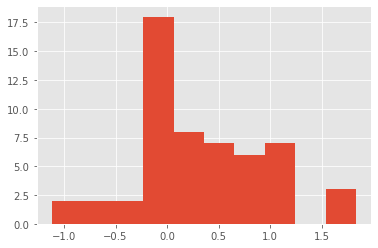

In [504]:
plt.hist(pb_data[11])